In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from tqdm import tqdm

from lib.formatter import *
from lib.conversions import *
from lib.detector_modelling import *
from lib.FT_modelling import *
from lib.synphot import *

In [2]:
num_positions = 16
remainder = 2*np.pi/num_positions
positions = np.linspace(-np.pi, np.pi-remainder, num=num_positions)

In [3]:
# Optical Architecture
aperture = 0.1 # m
central_obscuration = 0.011 # m, diameter
focal_length = 3.635 # m

# CCD Architecture
# detector_size = 2000
detector_size = 512
detector_pitch = 6.5e-6
fps = 7.5
QE = 0.9
read_noise = 1.6
dark_current = 0.68
gain = 1.29
full_well = 95e3

In [4]:
# Inputs for pysynphot
nwavels = 1001
wl_range = np.array([545e-9, 645e-9]) # Angstroms

In [5]:
# Stellar Parameters
acenA = {"mag":0.01, 
        "Teff":5790, 
        "Z": 0.2, 
        "log g": 4.30}

acenB = {"mag":1.33, 
        "Teff":5260, 
        "Z": 0.23, 
        "log g": 4.37}

In [6]:
# Create stellar observation object
acenA["obs"] = create_stellar_obs(aperture*100, central_obscuration*100, nwavels, wl_range*(10e9), acenA)
acenB["obs"] = create_stellar_obs(aperture*100, central_obscuration*100, nwavels, wl_range*(10e9), acenB)

# Uncomment this to get equal magnitudes (makes it easier to distinguish)
# acenB["obs"] = acenA["obs"]

# Calculate photon rate per second
acenA["rate/s"] = acenA["obs"].countrate() # Has units of counts per second
acenB["rate/s"] = acenB["obs"].countrate() # Has units of counts per second

# Caluate photon rate per frame
acenA["rate/frame"] = acenA["rate/s"]/fps
acenB["rate/frame"] = acenB["rate/s"]/fps

# Calculate the offset
acenA["coord"] = SkyCoord("14h39m36.49400s -60d50m02.3737s")
acenB["coord"] = SkyCoord("14h39m35.06311s -60d50m15.0992s")
azimuthal_offset = acenA["coord"].separation(acenB["coord"]).arcsec

In [7]:
print("Angular seperation in arcseconds: \n{:.2f}".format(azimuthal_offset))
pixel_sep = arcsec_to_pixel(azimuthal_offset, detector_pitch, focal_length)
print("Angular seperation in pixels: \n{:.2f}".format(pixel_sep))

Angular seperation in arcseconds: 
16.47
Angular seperation in pixels: 
44.66


In [36]:
a = rad_to_arcsec(np.arctan(6.5e-6/3.6))
L = 2*np.pi*azimuthal_offset
ratio = L/a
total_angle = 2*np.pi/ratio
angle_radians = 
print(total_angle)

0.02260898390311268


In [37]:
print(L)

103.49868043717339


In [8]:
#Input the raw the psf from zemax
psf_on_norm_zmx, psf_on_meta_data_zmx = zemax_to_array('files/on-axis_broadband.txt')
psf_off_norm_zmx, psf_off_meta_data_zmx = zemax_to_array('files/off-axis_broadband.txt')

In [9]:
# Normalise the zemax psfs to photon count per frame
psf_on_zmx = acenA["rate/frame"] * psf_on_norm_zmx / np.sum(psf_on_norm_zmx)
psf_off_zmx = acenB["rate/frame"] * psf_off_norm_zmx / np.sum(psf_off_norm_zmx)

In [26]:
%%time
zemax_pixel_size = 1.625e-6
detector_psfs_zmx = interpolate_to_detector([psf_on_zmx, psf_off_zmx], azimuthal_offset,\
                                        zemax_pixel_size, detector_pitch, focal_length, num_positions+1)[:-1]

CPU times: user 18.6 s, sys: 525 ms, total: 19.2 s
Wall time: 16.4 s


In [27]:
sums = [np.sum(psf) for psf in detector_psfs_zmx]

In [28]:
# zmx_images = []
# for psf in tqdm(detector_psfs):
#     im = CCD_output(psf, QE, read_noise, dark_current, fps, gain, full_well)
#     zmx_images.append(im)

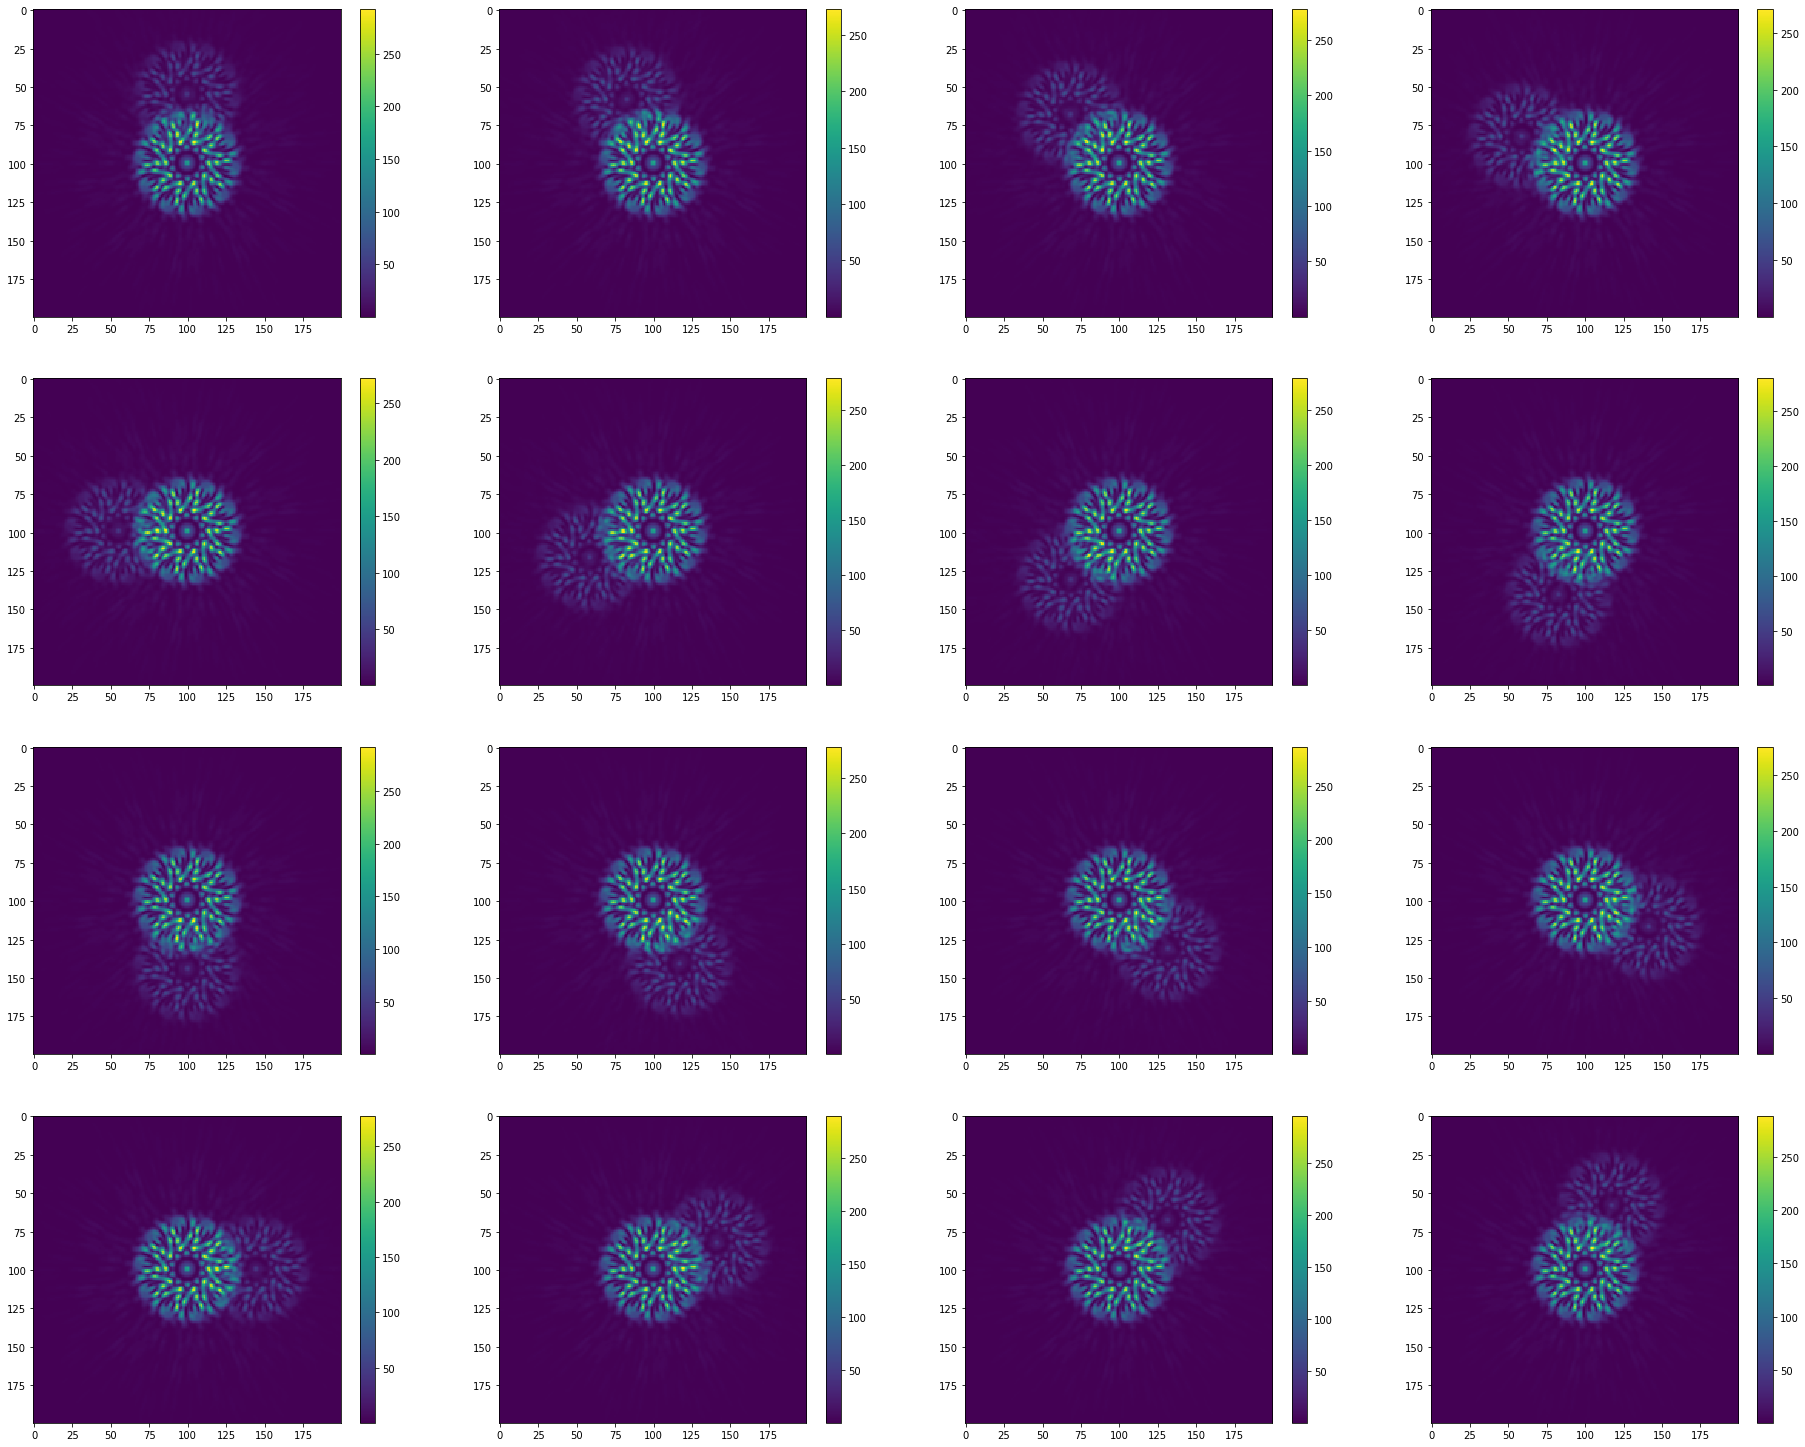

In [29]:
plt.figure(figsize=(32,26))
c = detector_psfs_zmx[0].shape[0]//2
s = 100
    
for i in range(num_positions):
    im = detector_psfs_zmx[i]
    plt.subplot(4,4,i+1)
    plt.imshow(im[c-s:c+s, c-s:c+s])
    plt.colorbar()

## Model fitting with FT's

In [30]:
pupil = pupil_from_fits("files/pupil_new_2k.fits")
wavelength  = 595e-9 # Central wavelength

In [16]:
%%time
# Create on axis psf for alpha cen A
psf_on_FT = model_FT(pupil, aperture, detector_size, wavelength, focal_length, detector_pitch)
psf_on_FT = acenA["rate/frame"] * psf_on_FT / np.sum(psf_on_FT)

CPU times: user 5.76 s, sys: 1.12 s, total: 6.89 s
Wall time: 4.07 s


In [17]:
%%time
detector_psfs_FT = []

for i in tqdm(range(num_positions)):
    angular_offset = positions[i]
    
    off_axis_pupil = pupil_phase_driver(pupil, aperture, wavelength, azimuthal_offset, angular_offset)
    psf_off_FT = model_FT(off_axis_pupil, aperture, detector_size, wavelength, focal_length, detector_pitch)
    
    psf_off_FT = acenB["rate/frame"] * psf_off_FT / np.sum(psf_off_FT)
    psf_out = psf_on_FT + psf_off_FT
    
    psf_out_remorn = sums[i] * psf_out / np.sum(psf_out)
    detector_psfs_FT.append(psf_out_remorn)

100%|██████████| 16/16 [00:59<00:00,  3.63s/it]

CPU times: user 1min 35s, sys: 12.5 s, total: 1min 48s
Wall time: 59.5 s


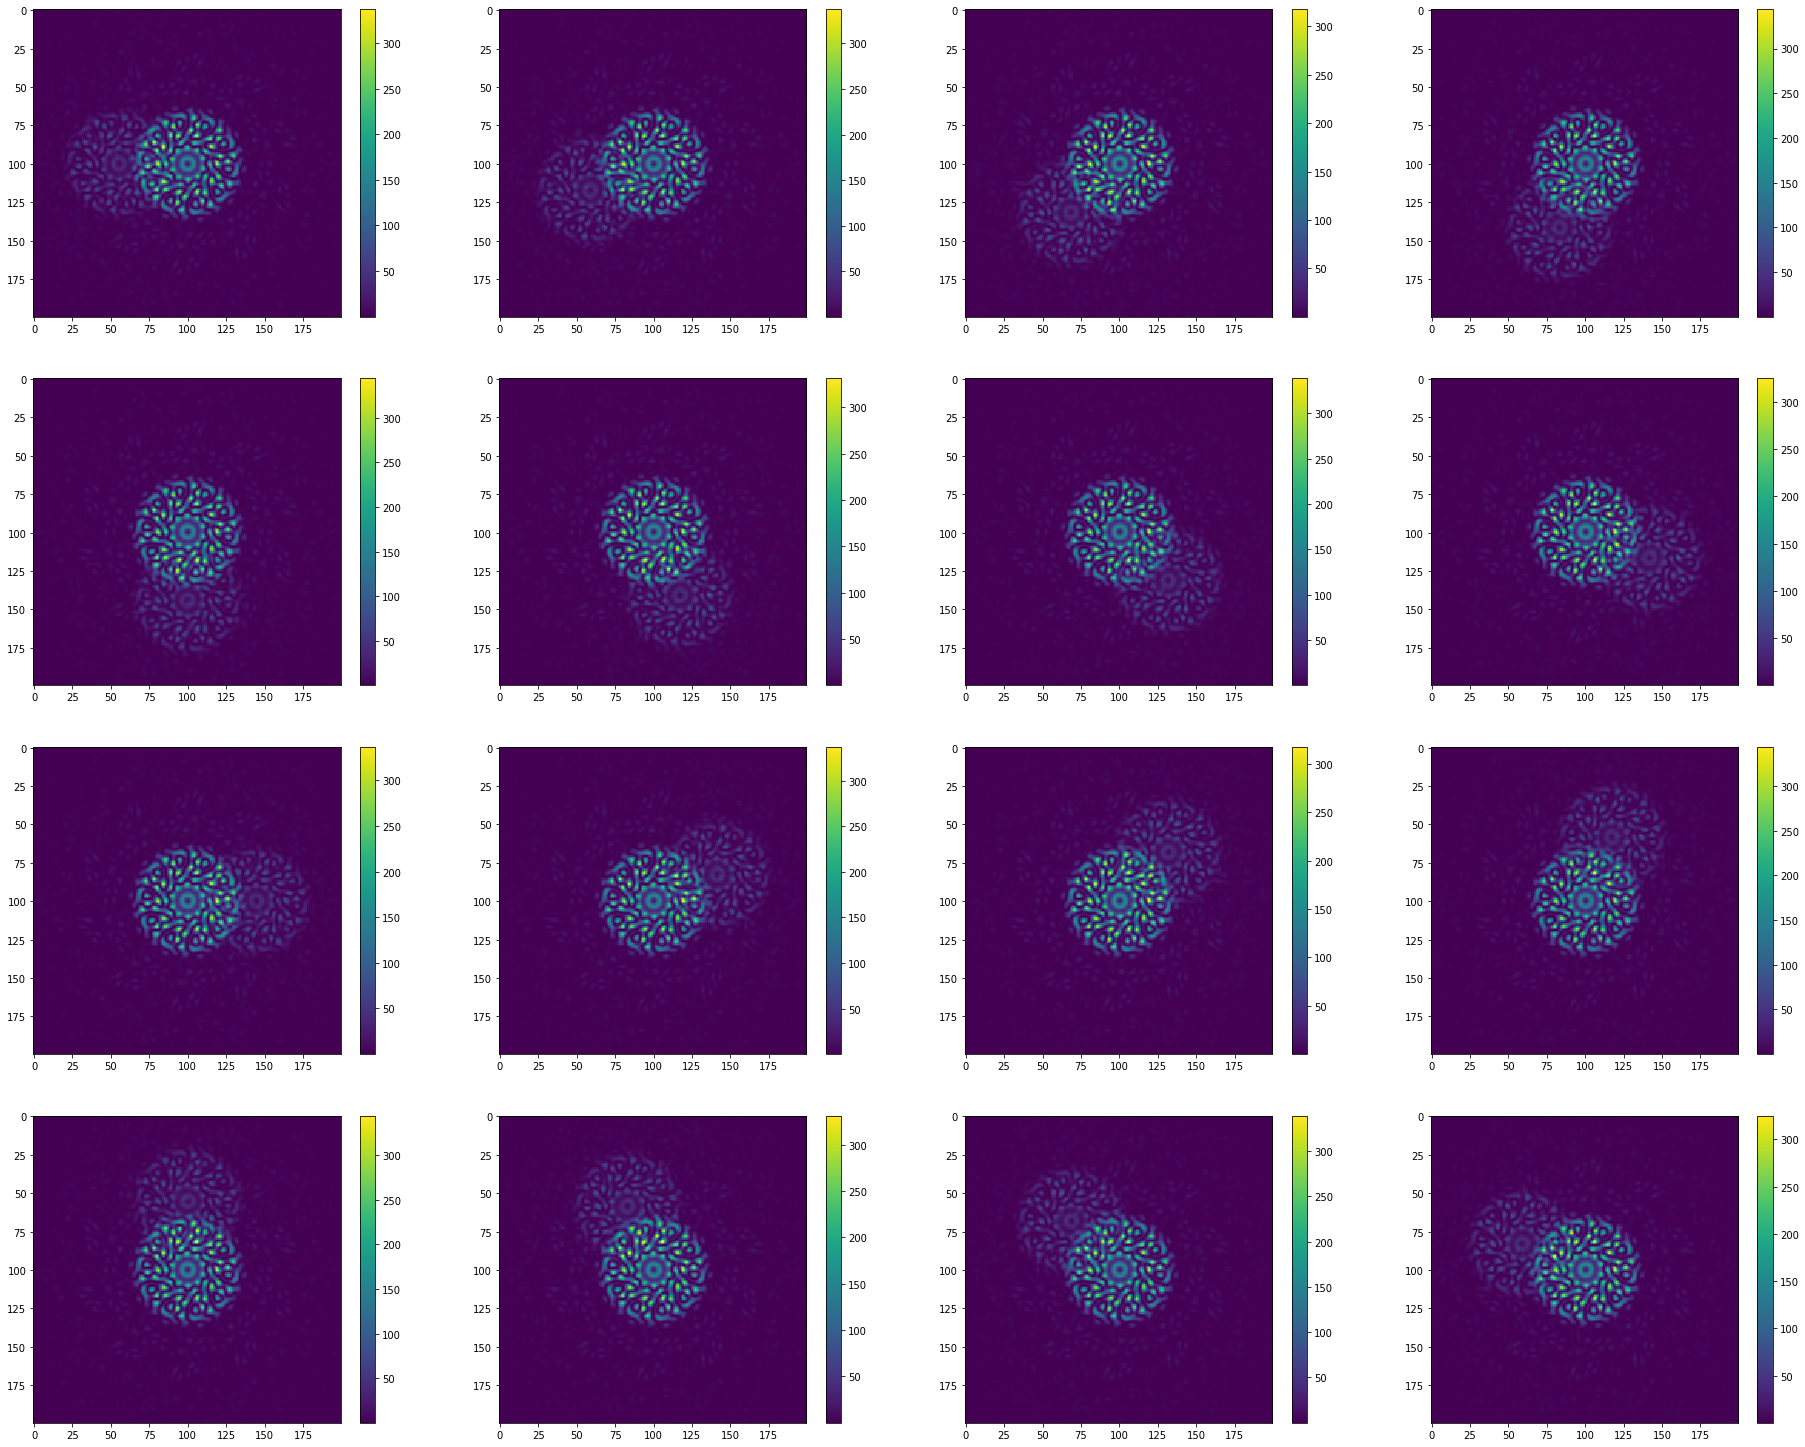

In [31]:
plt.figure(figsize=(32,26))
c = detector_psfs_FT[0].shape[0]//2
s = 100
    
for i in range(num_positions):
    im = detector_psfs_FT[i]
    plt.subplot(4,4,i+1)
    plt.imshow(im[c-s:c+s, c-s:c+s])
    plt.colorbar()

100%|██████████| 16/16 [00:03<00:00,  2.91it/s]


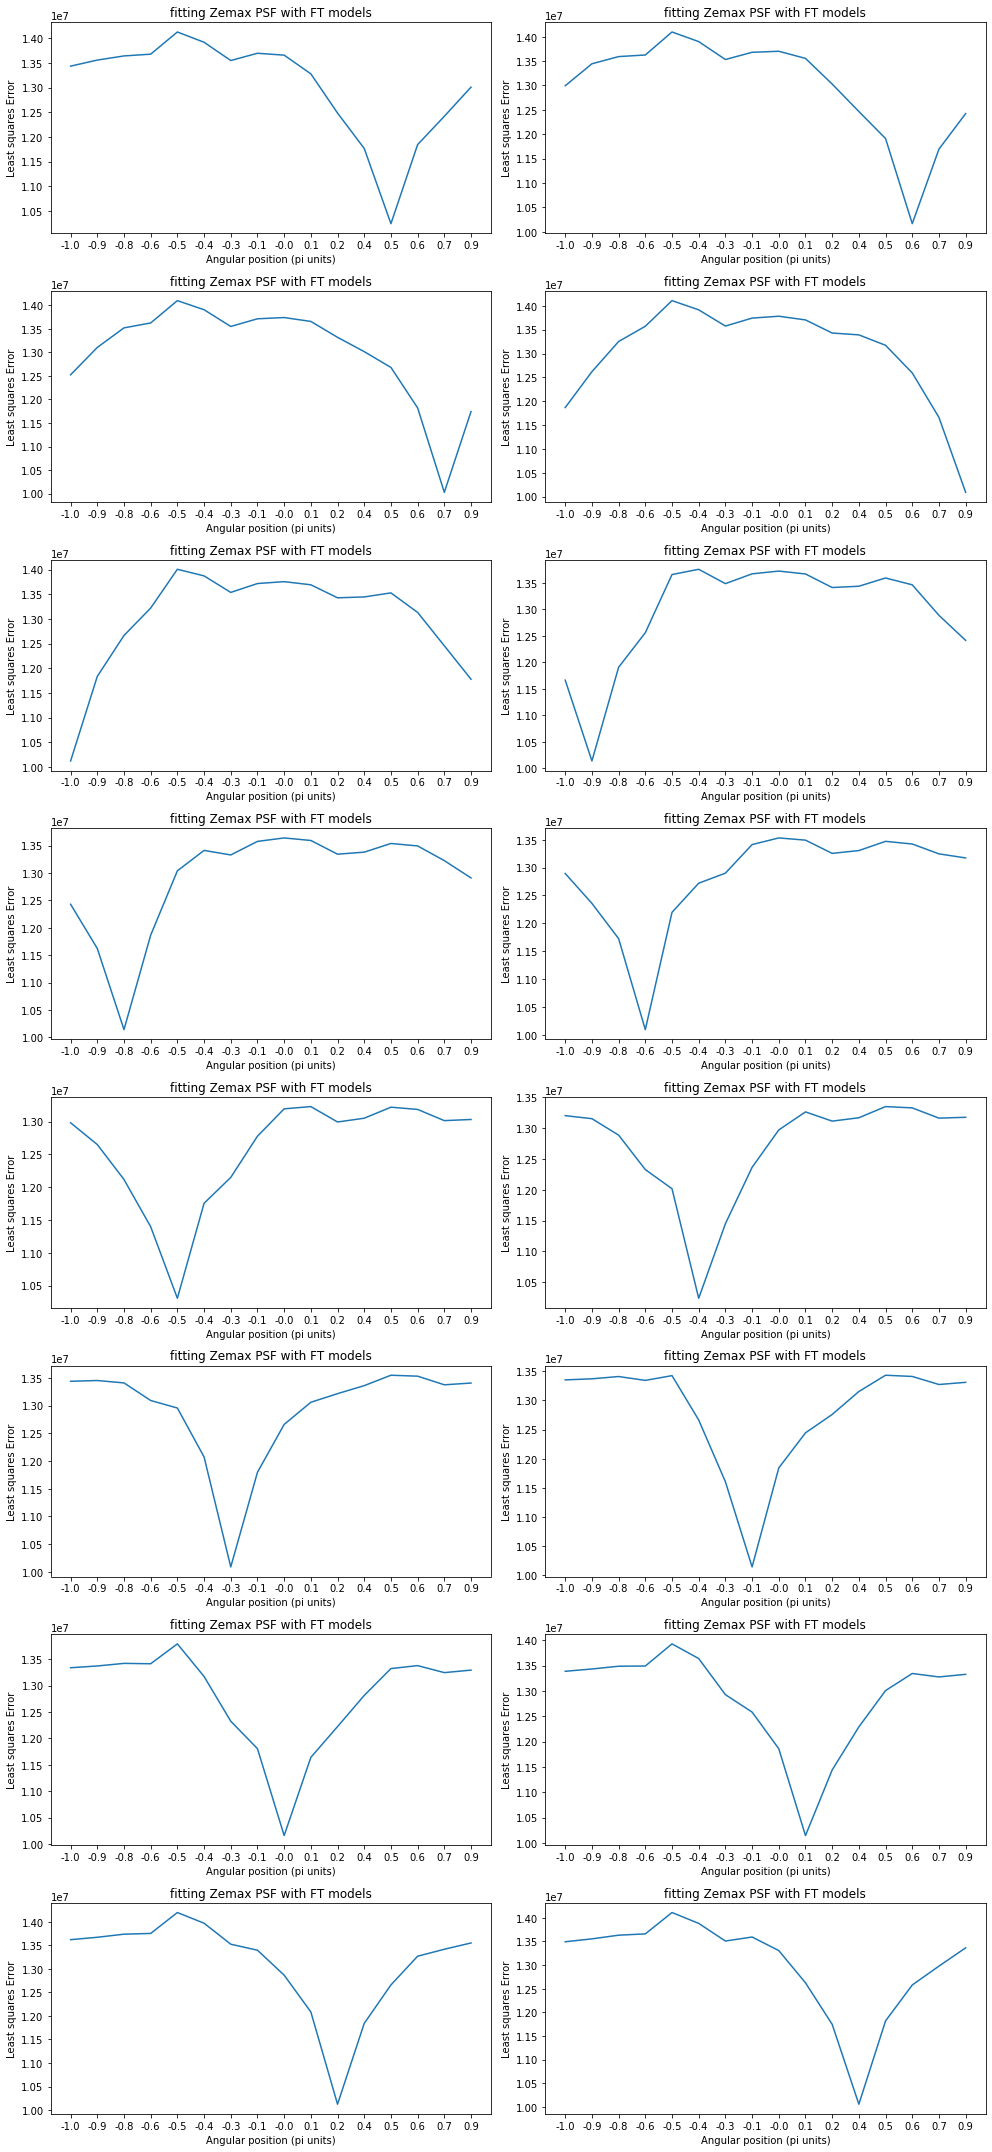

In [32]:
plt.figure(figsize=(14,30))
pos = ["{:.1f}".format(p/np.pi) for p in positions]

for i in tqdm(range(num_positions)):
    data_psf = detector_psfs_zmx[i]
    
    diffs = []
    squares = []
    vals = []
    for j in range(num_positions):
        fitting_psf = detector_psfs_FT[j]
        
        diff = data_psf - fitting_psf
        diffs.append(diff)
        
        square = diff**2
        squares.append(square)
        
        val = np.sum(square)
        vals.append(val)
        
    plt.subplot(8, 2, i+1)
    plt.tight_layout()
    plt.title("fitting Zemax PSF with FT models")
    plt.ylabel("Least squares Error")
    plt.xlabel("Angular position (pi units)")
    plt.xticks(np.linspace(0,num_positions,num=num_positions+1), pos)
    plt.plot(vals)